Nesse notebook iremos fazer uma breve analise acerca de um dataset sobre a avaliação de uma empresa de acordo com os tuites sobre a mesma; as avaliações podem ser positivas, negativas ou neutras. O inutuito é mostrar um pipeline básico de como fazer um processamento básico de linguagem natural.

In [ ]:
O pipeline básico que iremos seguir é:
    > limpeza dos dados
    > formatação do arquivo csv
    > remoção de stop words (se necessário)
    > stemmização (se necessário)
    > contagem de palavras (CountVectorizer ou TfIdfVectorizer)
    > treinamento do modelo
    > análise dos resultados (matriz de confusão e palavras com mais peso na escolha das classes)

Primeiro iremos importar as bibliotecas que iremos usar ao longo do notebook.

In [66]:
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

Iremos agora a primeira etapa que consiste na limpeza dos dados.

Temos antes de tudo os dados brutos.

In [67]:
reviews = pd.read_csv('Tweets.csv')

reviews

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


Agora vamos a limpeza básica.

In [68]:
def limpa(text):
    text = re.sub('@\w+',"",text)
    text = re.sub('#\w+','',text)
    text = re.sub('https?:\/\/[\w\.\/]+[,"]?','',text)
    text = text.lower()
    return text

def labela(text):
    if(text == 'positive'):
        return 1
    if(text == 'neutral'):
        return 2
    if(text == 'negative'):
        return 3

In [69]:
novo = pd.DataFrame()

novo['avaliacao'] = reviews['airline_sentiment']
novo['twet'] = reviews['text']

novo['twet'] = novo['twet'].apply(limpa)

novo['class_label'] = novo['avaliacao'].apply(labela)


novo.to_csv('avaliText.csv',index=False)

novo

,avaliacao,twet,class_label
0,neutral,what said.,2
1,positive,plus you've added commercials to the experien...,1
2,neutral,i didn't today... must mean i need to take an...,2
3,negative,"it's really aggressive to blast obnoxious ""en...",3
4,negative,and it's a really big bad thing about it,3
...,...,...,...
14635,positive,thank you we got on a different flight to chi...,1
14636,negative,leaving over 20 minutes late flight. no warni...,3
14637,neutral,please bring american airlines to,2
14638,negative,"you have my money, you change my flight, and ...",3


Removemos @'s e #'s e também links para deixar no texto só o corpo e colocamos tudo em lower case, depois rotulamos as avaliações: 1 para positivos, 2 neutro, e 3 negativo.

Agora veremos a distrubuição das avaliações, procurando a quantidade de elementos em cada classe.

In [70]:
limpos = pd.read_csv('avaliText.csv')

limpos.groupby('avaliacao').count()

,twet,class_label
avaliacao,,
negative,9178,9178
neutral,3099,3099
positive,2363,2363


Vemos então que a quantidade de tuites negativos sobre a empresa é bem maior que positivos e negativos, já podemos retirar informações sobre isso: o que pode significar que a empresa não fornece um bom serviço, ou os dados são viesados.

Agora veremos as palavras mais frequentes de cada classe para verificar se isso nos trás alguma nova informação.

In [71]:
def plota_mais_ocorridas(data,label,legenda,cv):
    count = cv
    count.fit(data[label])
    dic = count.vocabulary_.items()

    vocab = []
    count = []

    for v,c in dic:
        vocab.append(v)
        count.append(c)
    
    serie = pd.Series(count,index=vocab)

    serie_ordenada = serie.sort_values(ascending=False)

    top_serie = serie_ordenada.head(20)

    top_serie.plot(kind = 'barh')

    plt.title(legenda)

    plt.show()

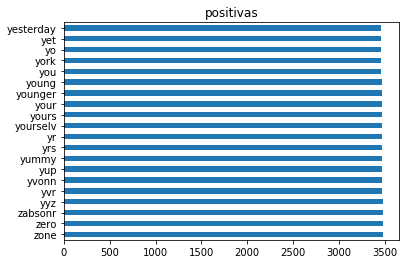

In [72]:
limpos['twet'] = limpos['twet'].apply(stemma)

positivas = limpos[limpos['class_label'] == 1]
neutras = limpos[limpos['class_label'] == 2]
negativas = limpos[limpos['class_label'] == 3]

cv = TfidfVectorizer()
plota_mais_ocorridas(positivas,'twet',"positivas",cv)


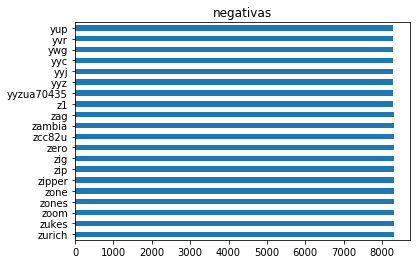

In [73]:
plota_mais_ocorridas(negativas,'twet','negativas',cv)

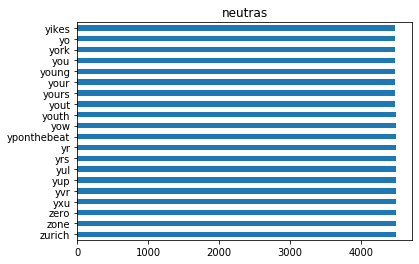

In [74]:
plota_mais_ocorridas(neutras,'twet',"neutras",cv)

As palavras mais frequentes de cada classe não nos fornecem boas estimativas sobre os representantes de cada classe.

Ainda com os dados em parte brutos vamos treinar um modelo (Regressão logística) para ver como ele se sai.

In [75]:
cv = CountVectorizer()

twets = limpos['twet'].tolist()
classe = limpos['class_label'].tolist()

xtrain,ytest, xright, yright = train_test_split(twets,classe)

xtrain = cv.fit_transform(xtrain)
ytest = cv.transform(ytest)

Criamos os splits de teste para treinar e testar nosso modelo.

In [76]:
model = LogisticRegression(solver='newton-cg',multi_class='multinomial')

model.fit(xtrain,xright)

output = model.predict(ytest)

E treinamos.

Vamos analisar os resultados do nosso modelo de treinamento.

In [77]:
precision = precision_score(yright,output,average='weighted',pos_label=None)

print("Tivemos uma precisão de:",precision)

Tivemos uma precisão de: 0.7791173309009559


In [78]:
print("E a matriz de confusão, note que ela está indexada de 1 2 3 da esquerda para direita e 1 2 3 de cima para baixo")
cm = confusion_matrix(yright,output)

print(cm)


E a matriz de confusão, note que ela está indexada de 1 2 3 da esquerda para direita e 1 2 3 de cima para baixo
[[ 378   84  114]
 [  78  441  246]
 [  71  199 2049]]


Note que nosso maior erro foi de classificar tuites negativos como positivos e neutros, mas os resultados foram bons.

Agora veremos quais palavras tiveram mais peso para classificar os tuites como positivo, neutro ou negativo.

In [79]:
def get_most_important(cv,model,n = 10):
    dici = {v:k for k,v in cv.vocabulary_.items()}

    classes = {}

    for i in range(len(model.coef_)):
        palavras = [(dici[indice],peso) for indice,peso in enumerate(model.coef_[i])]
        palavras = sorted(palavras,key=lambda x: x[1],reverse=True)
        classes[i+1] = palavras[:n]

    return classes


In [80]:
dicionario = get_most_important(cv,model,10)

print("\nPositivas:")
for i, j in dicionario[1]:
    print(i,j)



Positivas:
great 2.3335751001587948
thanks 2.0072540315533236
awesome 1.9857881567812532
thank 1.9540156572986214
love 1.7585297204120443
best 1.6894022627972636
amaz 1.6482674399901185
thx 1.6034585621134725
excel 1.552110144008717
excit 1.5078539123192793


In [81]:

print("\nNeutras")
for i, j in dicionario[2]:
    print(i,j)



Neutras
polici 1.3281924358375352
winner 1.2342577296040116
appli 1.1679301953749988
winter 1.1601468612725903
suggestions 1.126719641162609
mexico 1.1222278651173647
upcom 1.0581813290186926
tourist 1.009371681358588
28 1.007622113078772
cal 0.9566131620698416


In [82]:

print("\nNegativas")
for i, j in dicionario[3]:
    print(i,j)



Negativas
worst 2.4978890270185925
nothing 1.9327141858913433
suck 1.4953083434379602
rude 1.4408330131116374
communic 1.4265040552042112
delayed 1.4214194929008843
delay 1.3893771909272743
lost 1.388978759801894
fuck 1.3817349080504013
lie 1.3762218680380474


Como podemos ver, as palavras com mais peso para classificar positivas e negativas parecem corresponder
ao esperado, mas as usadas para classificar neutros parecem um pouco aleatórias.

Tentaremos refinar mais nossos dados para verificar se conseguimos resultados melhores usando stemmização, removendo stop words e para a bag of words usaremos tfidf.

In [83]:
def stemma(text):

    words = [stemmer.stem(word) for word in text.split()]
    return " ".join(words)

sw = stopwords.words('english')

def remove_stop(text):
    words = [word for word in text.split() if word not in sw]
    return " ".join(words)

In [95]:
limpos['twet'] = limpos['twet'].apply(stemma)
limpos['twet'] = limpos['twet'].apply(remove_stop)

limpos

,avaliacao,twet,class_label
0,neutral,said.,2
1,positive,plus you'v ad commerci experience... tacky.,1
2,neutral,today... must mean need take anoth trip!,2
3,negative,"realli aggress blast obnoxi ""entertainment"" gu...",3
4,negative,realli big bad thing,3
...,...,...,...
14635,positive,thank got differ flight chicago.,1
14636,negative,leav 20 minut late flight. warn communic 15 mi...,3
14637,neutral,plea bring american airlin,2
14638,negative,"money, chang flight, answer phones! ani sugges...",3


Aplicamos a stemmização e removemos stop words.

In [113]:
cv = TfidfVectorizer()

twets = limpos['twet'].tolist()
classe = limpos['class_label'].tolist()

xtrain,ytest, xright, yright = train_test_split(twets,classe)

xtrain = cv.fit_transform(xtrain)
ytest = cv.transform(ytest)

Usamos tfidf para contar a frequencia das palavras no texto.

In [114]:
model = LogisticRegression(solver='newton-cg',multi_class='multinomial')

model.fit(xtrain,xright)

output = model.predict(ytest)

E treinamos nosso modelo.

Agora vamos verificar os resultados que nós conseguimos.

In [115]:
precision = precision_score(yright,output,average='weighted',pos_label=None)

print("Tivemos uma precisão de:",precision)

Tivemos uma precisão de: 0.7692754715560198


Uma precisão um pouco menor que obtivemos nos dados brutos. Vamos investigar por que isso aconteceu mesmo tratando mais os dados.

In [116]:
print("\nA a matriz de confusão, note que ela está indexada de 1 2 3 da esquerda para direita e 1 2 3 de cima para baixo")
cm = confusion_matrix(yright,output)

print(cm)


A a matriz de confusão, note que ela está indexada de 1 2 3 da esquerda para direita e 1 2 3 de cima para baixo
[[ 351   67  194]
 [  48  357  394]
 [  29   93 2127]]


O maior erro ainda se concentra nas palavras neutras. Vamos investigar as palavras mais usadas.

In [117]:
dicionario = get_most_important(cv,model,10)

In [118]:
print("\nPositivas:")
for i, j in dicionario[1]:
    print(i,j)


Positivas:
thank 5.070381037353747
great 4.123738749468479
love 3.579662003524857
thanks 3.460729938640896
best 2.8452911383726103
awesome 2.759432141676079
awesom 2.589782707334518
thx 2.4976575312192693
amazing 2.387884765573726
appreci 2.213853355807162


In [119]:
print("\nNeutras")
for i, j in dicionario[2]:
    print(i,j)



Neutras
ani 1.945759018457799
hi 1.7278346419535886
question 1.6501060253845043
polici 1.5584318869425093
possibl 1.4573958219648866
current 1.3879242252320723
saw 1.3586066285690819
tomorrow 1.2710735109536584
dm 1.2555536911055913
winner 1.234030511677877


In [120]:
print("\nNegativas")
for i, j in dicionario[3]:
    print(i,j)


Neegativas
hour 3.796905436215692
hold 3.1708137422688067
worst 3.122152027805165
delay 3.0834200085817165
cancel 2.8171289940770228
bag 2.5593374903185095
call 2.471659492947176
becaus 2.329451235341278
whi 2.285438384595567
luggag 2.23492703068891


Vemos que mesmo limpando os dados as palavras mais utilizadas não mudaram tanto, talvez devessemos tentar limpar nossos dados ou até procurar outro modelo que melhor represente essa situação.